In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import os
import glob
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
DB_PATH = "./dbNudeDetection/"

if not(os.path.isdir(DB_PATH+"nude")):
    os.mkdir(DB_PATH+"nude")
if not(os.path.isdir(DB_PATH+"non_nude")):
    os.mkdir(DB_PATH+"non_nude")

files = glob.glob(DB_PATH+"/*.jpg")
if len(files):
    for i in range(len(files)):
        files[i] = files[i][len("./dbNudeDetection\\"):]
        if files[i][:4] == "nude":
            shutil.move(DB_PATH+files[i], DB_PATH+"/nude/"+files[i])
        else:
            shutil.move(DB_PATH+files[i], DB_PATH+"/non_nude/"+files[i])
    
files

# if len(files)!=0:
#     for i in files:

[]

In [3]:
# transformations = transforms.Compose([transforms.Resize((224,224)),
#                                     transforms.RandomRotation(50),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.CenterCrop(200),
#                                     transforms.Grayscale(),
#                                     transforms.ToTensor(), 
#                                     transforms.Normalize((0.5,), (0.5,))])

train_transform = transforms.Compose([transforms.Resize(255),transforms.RandomResizedCrop(224),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor()])
test_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

In [4]:
train_data = torchvision.datasets.ImageFolder(r"dbNudeDetection\train", transform=train_transform)
test_data = torchvision.datasets.ImageFolder(r"dbNudeDetection\val", transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [5]:
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(58320, 1024)
        self.fc2 = nn.Linear(1024, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model=Binary_Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
train_losses = []
from tqdm import tqdm
for epoch in tqdm(range(1,16)):
    train_loss = 0.0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #backward-pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Update the Training loss
        train_loss += loss.item() * data.size(0)
    train_losses.append(train_loss)

100%|██████████| 15/15 [01:18<00:00,  5.25s/it]


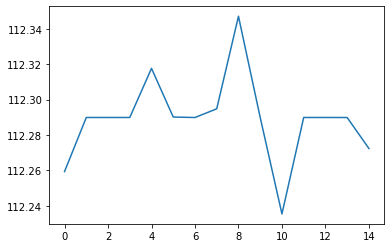

In [17]:
plt.plot(range(15),train_losses)

In [18]:
torch.save(model, "Model1.h5")

In [19]:
model = torch.load('Model1.h5')
model.eval()

Binary_Classifier(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=58320, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [20]:
from PIL import Image
classes = ["non nude","nude"]
def pre_image(image_path,model):
   img = Image.open(image_path)
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   transform_norm = transforms.Compose([transforms.Resize(255),
   transforms.CenterCrop(224),
   transforms.ToTensor()
   ])
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      class_name = classes[index]
      return class_name

pre_image(r"0aeSdIV.jpg",model)

'non nude'

In [11]:
# model.eval()
# # iterate over test data
# len(test_loader)
# for data, target in test_loader:
#     # move tensors to GPU if CUDA is available
#     if train_on_gpu:
#         data, target = data.cuda(), target.cuda()
#     # forward pass
#     output = model(data)
#     # calculate the batch loss
#     loss = criterion(output, target)
#     # update test loss 
#     test_loss += loss.item()*data.size(0)
#     # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)    
#     # compare predictions to true label
#     correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
#     # calculate test accuracy for each object class
#     for i in range(batch_size):       
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1
# # average test loss
# test_loss = test_loss/len(test_loader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))
# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))

In [12]:
# CLASSES = ["Nude", "Non-Nude"]
# NUM_CLASSES = len(CLASSES)

# class ImageMulticlassClassificationNet(nn.Module):
#     def __init__(self) -> None:
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 6, 3)  
#         self.pool = nn.MaxPool2d(2, 2)  
#         self.conv2 = nn.Conv2d(6, 16, 3) 
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(16 * 11 * 11, 128) # out: (BS, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, NUM_CLASSES)
#         self.relu = nn.ReLU()
#         self.softmax = nn.LogSoftmax()
    
#     def forward(self, x):
#         x = self.conv1(x) # out: (BS, 6, 48, 48)
#         x = self.relu(x)
#         x = self.pool(x) # out: (BS, 6, 24, 24)
#         x = self.conv2(x) # out: (BS, 16, 22, 22)
#         x = self.relu(x)
#         x = self.pool(x) # out: (BS, 16, 11, 11)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = self.softmax(x)
#         return x

# class ImageClassificationNet(nn.Module):
#     def __init__(self) -> None:
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 6, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 3)
#         self.fc1 = nn.Linear(16 * 6 * 6, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 1)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = self.sigmoid(x)
#         return x
    
    

In [13]:
# model = ImageClassificationNet()      
# loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
# NUM_EPOCHS = 10
# for epoch in range(NUM_EPOCHS):
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data
#         optimizer.zero_grad()
#         outputs = model(inputs)
        
#         loss = loss_fn(outputs, labels.reshape(-1, 1).float())
#         loss.backward()
#         optimizer.step()
#         if i % 100 == 0:
#             print(f'Epoch {epoch}/{NUM_EPOCHS}, Step {i+1}/{len(trainloader)},'
#                   f'Loss: {loss.item():.4f}')

In [14]:
# y_test = []
# y_test_hat = []
# for i, data in enumerate(testloader, 0):
#     inputs, y_test_temp = data
#     with torch.no_grad():
#         y_test_hat_temp = model(inputs).round()
    
#     y_test.extend(y_test_temp.numpy())
#     y_test_hat.extend(y_test_hat_temp.numpy())

# # %%
# acc = accuracy_score(y_test, np.argmax(y_test_hat, axis=1))
# print(f'Accuracy: {acc*100:.2f} %')
# # %% confusion matrix
# confusion_matrix(y_test, np.argmax(y_test_hat, axis=1))
# # %%